In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [3]:
from intlib.integrators import RK3Integrator, RKLikeMatrixIntegrator, TaylorSeriesIntegrator
from intlib.targets import VanderPolTarget, BrusselatorTarget
from intlib.evaluators import GMeanEvaluator

In [4]:
def plot(df): 
    plt.plot(df.index, df[('value','GMean')], color = 'darkslateblue',marker = '*',label='NN')
    plt.fill_between(df.index, df[('value','amin')], df[('value','amax')], color='lightsteelblue')
    plt.plot(df.index, df[('ty','GMean')], color = 'darkgreen',marker = 's',label='Taylor Series')
    plt.plot(df.index, df[('rk','GMean')], color = 'chocolate',marker = 'o',label='RK3')
    plt.xlabel(r'$h$')
    plt.ylabel('Relative Error')
    plt.xscale('log')
#     plt.yscale('log')
    plt.legend()

In [5]:
def GMean(value):
    multiply = 1
    for i in value:
        multiply = (multiply)*(i)
    GMean = (multiply)**(1/len(value))
    return GMean

In [6]:
dim = 2

In [7]:
n_samples=10
T = 1

In [8]:
# Use geometric mean because we compare the relative error.
evaluator_GMean = GMeanEvaluator() 

In [9]:
hrange = (-1,-2) # If want to see the evaluation over range of h, please edit hrange here.

# Plot on Vander Pol Oscillator

In [10]:
target_1 = VanderPolTarget(dim=dim)
rk3 = RK3Integrator(target=target_1, dim=dim)
taylorseries = TaylorSeriesIntegrator(target=target_1, dim=dim)

integrator_stage = 3
taylorloss_order = 3

rk_nn_1 = RKLikeMatrixIntegrator(target=target_1, dim=dim, order=integrator_stage)

## Create the DataFrame

In [11]:
df_1 = pd.DataFrame()

In [12]:
hs, errors_rk_mse = evaluator_GMean.evaluate(integrator=rk3, target=target_1, n_samples=n_samples, T=T, hrange=hrange)
hs, errors_ty_mse = evaluator_GMean.evaluate(integrator=taylorseries, target=target_1, n_samples=n_samples, T=T, hrange=hrange)

100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


In [13]:
for i in range(5):
    rk_nn_1.model.load_weights('results/VanderPol/weights/vdp_rk3_'+str(i)+'.h5')
    hs, errors_nn_mse = evaluator_GMean.evaluate(integrator=rk_nn_1, target=target_1, n_samples=n_samples, T=T, hrange=hrange)    
    df_1['nn'+str(i+1)] = np.array(errors_nn_mse) / np.array(errors_rk_mse)

100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


In [14]:
df_1['rk'] = np.array(errors_rk_mse) / np.array(errors_rk_mse)
df_1['ty'] = np.array(errors_ty_mse) / np.array(errors_rk_mse)
df_1['hs'] = hs

In [15]:
m_1 = pd.melt(df_1, id_vars=['hs','rk','ty'])
# get mean/std
summary_1 = m_1.groupby('hs').agg([GMean, np.max, np.min])

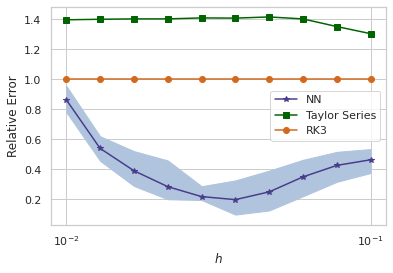

In [16]:
plot(summary_1)
# plt.text(10**-1.85, 10**1.5, 'h in training range', style='italic',
#         bbox={'facecolor': 'thistle', 'alpha': 0.5, 'pad': 5})
# plt.text(10**-2.95, 10**1.5, 'h out of training range', style='italic',
#         bbox={'facecolor': 'thistle', 'alpha': 0.5, 'pad': 5})
# plt.vlines(10**-2, 10**-1, 10**3, colors = 'black', linestyles = "dashed")
# plt.savefig('results/VanderPol/vdp_RandomAll_GMean_h_out.pdf', dpi=200, bbox_inches='tight')

## Random $y_{0}$, outside $\alpha$

In [17]:
alphas = tf.random.uniform(
            minval=0,
            maxval=1,
            shape=(n_samples, 1,1,1),
            dtype='float64'
        )

In [18]:
df_11 = pd.DataFrame()
hs, errors_rk_mse = evaluator_GMean.evaluate(integrator=rk3, target=target_1, n_samples=n_samples,alpha=alphas,T=T)
hs, errors_ty_mse = evaluator_GMean.evaluate(integrator=taylorseries, target=target_1, n_samples=n_samples, 
                                             alpha=alphas, T=T)

for i in range(5):
    rk_nn_1.model.load_weights('results/VanderPol/weights/vdp_rk3_'+str(i)+'.h5')
    hs, errors_nn_mse = evaluator_GMean.evaluate(integrator=rk_nn_1, target=target_1, n_samples=n_samples,alpha=alphas,T=T)    
    df_11['nn'+str(i+1)] = np.array(errors_nn_mse)/np.array(errors_rk_mse)

df_11['rk'] = np.array(errors_rk_mse)/np.array(errors_rk_mse)
df_11['ty'] = np.array(errors_ty_mse)/np.array(errors_rk_mse)
df_11['hs'] = hs

m_11 = pd.melt(df_11, id_vars=['hs','rk','ty'])
# get mean/std
summary_11 = m_11.groupby('hs').agg([GMean, np.max, np.min])

100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


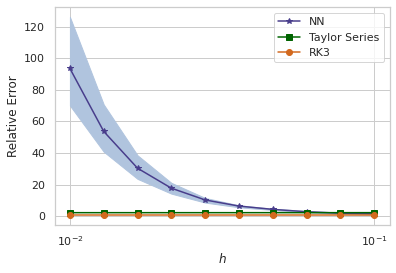

In [19]:
plot(summary_11)
# plt.savefig('results/VanderPol/vdp_alphaOutside_0_1_GMean.pdf', dpi=200, bbox_inches='tight')

## Random $\alpha$, outside $y_{0}$

### $\alpha$  in symmetric interval

In [20]:
y1 = tf.random.uniform(    
    minval=3.0,
    maxval=4.0,
    shape=(n_samples, 1),
    dtype='float64'
)

y2 = tf.random.uniform(
    minval=-2.0,
    maxval=0.0,
    shape=(n_samples, 1),
    dtype='float64'
)
y0s = tf.concat([y1,y2], axis=-1)

In [21]:
df_12 = pd.DataFrame()
hs, errors_rk_mse = evaluator_GMean.evaluate(integrator=rk3, target=target_1, n_samples=n_samples, y0=y0s, T=T)
hs, errors_ty_mse = evaluator_GMean.evaluate(integrator=taylorseries, target=target_1, n_samples=n_samples, y0=y0s, T=T)

for i in range(5):
    rk_nn_1.model.load_weights('results/VanderPol/weights/vdp_rk3_'+str(i)+'.h5')
    hs, errors_nn_mse = evaluator_GMean.evaluate(integrator=rk_nn_1, target=target_1, n_samples=n_samples, y0=y0s, T=T)    
    df_12['nn'+str(i+1)] = np.array(errors_nn_mse)/np.array(errors_rk_mse)

df_12['rk'] = np.array(errors_rk_mse)/np.array(errors_rk_mse)
df_12['ty'] = np.array(errors_ty_mse)/np.array(errors_rk_mse)
df_12['hs'] = hs

m_12 = pd.melt(df_12, id_vars=['hs','rk','ty'])
# get mean/std
summary_12 = m_12.groupby('hs').agg([GMean, np.max, np.min])

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


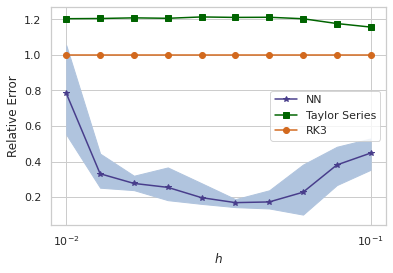

In [22]:
plot(summary_12)
# plt.savefig('results/VanderPol/vdp_y0Outside_GMean.pdf', dpi=200, bbox_inches='tight')

### $\alpha$ totally outside training range

In [23]:
y1 = tf.random.uniform(    
    minval=-1.0,
    maxval=1.0,
    shape=(n_samples, 1),
    dtype='float64'
)

y2 = tf.random.uniform(
    minval=-1.0,
    maxval=1.0,
    shape=(n_samples, 1),
    dtype='float64'
)
y0s = tf.concat([y1,y2], axis=-1)

In [24]:
df_13 = pd.DataFrame()
hs, errors_rk_mse = evaluator_GMean.evaluate(integrator=rk3, target=target_1, n_samples=n_samples, y0=y0s, T=T)
hs, errors_ty_mse = evaluator_GMean.evaluate(integrator=taylorseries, target=target_1, n_samples=n_samples, y0=y0s, T=T)

for i in range(5):
    rk_nn_1.model.load_weights('results/VanderPol/weights/vdp_rk3_'+str(i)+'.h5')
    hs, errors_nn_mse = evaluator_GMean.evaluate(integrator=rk_nn_1, target=target_1, n_samples=n_samples, y0=y0s, T=T)    
    df_13['nn'+str(i+1)] = np.array(errors_nn_mse)/np.array(errors_rk_mse)

df_13['rk'] = np.array(errors_rk_mse)/np.array(errors_rk_mse)
df_13['ty'] = np.array(errors_ty_mse)/np.array(errors_rk_mse)
df_13['hs'] = hs

m_13 = pd.melt(df_13, id_vars=['hs','rk','ty'])
# get mean/std
summary_13 = m_13.groupby('hs').agg([GMean, np.max, np.min])

100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


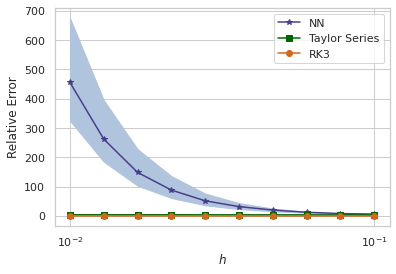

In [25]:
plot(summary_13)
# plt.savefig('results/VanderPol/vdp_y0Outside_GMean.pdf', dpi=200, bbox_inches='tight')

# Plot on the Brusselator

In [26]:
target_2 = BrusselatorTarget(dim=dim)  # y**2
rk3 = RK3Integrator(target=target_2, dim=dim)
taylorseries = TaylorSeriesIntegrator(target=target_2, dim=dim)
evaluator_GMean = GMeanEvaluator()

integrator_stage = 3
taylorloss_order = 3

rk_nn_2 = RKLikeMatrixIntegrator(target=target_2, dim=dim, order=integrator_stage)

In [27]:
df_2 = pd.DataFrame()

In [28]:
hs, errors_rk_mse = evaluator_GMean.evaluate(integrator=rk3, target=target_2, n_samples=n_samples, hrange=hrange)
hs, errors_ty_mse = evaluator_GMean.evaluate(integrator=taylorseries, target=target_2, n_samples=n_samples, hrange=hrange)

for i in range(3):
    rk_nn_2.model.load_weights('results/Brusselator/weights/bru_rk3_'+str(i)+'.h5')
    hs, errors_nn_mse = evaluator_GMean.evaluate(integrator=rk_nn_2, target=target_2, n_samples=n_samples, hrange=hrange)    
    df_2['nn'+str(i+1)] = np.array(errors_nn_mse)/np.array(errors_rk_mse)

df_2['rk'] = np.array(errors_rk_mse)/np.array(errors_rk_mse)
df_2['ty'] = np.array(errors_ty_mse)/np.array(errors_rk_mse)
df_2['hs'] = hs

m_2 = pd.melt(df_2, id_vars=['hs','rk','ty'])
# get mean/std
summary_2 = m_2.groupby('hs').agg([GMean, np.max, np.min])

100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


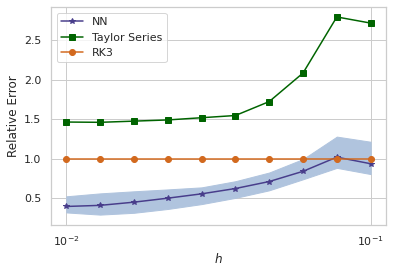

In [29]:
plot(summary_2)
# plt.text(10**-1.85, 4, 'h in training range', style='italic',
#         bbox={'facecolor': 'thistle', 'alpha': 0.5, 'pad': 5})
# plt.text(10**-2.95, 4, 'h out of training range', style='italic',
#         bbox={'facecolor': 'thistle', 'alpha': 0.5, 'pad': 5})
# plt.vlines(10**-2, 0, 7.5, colors = 'black', linestyles = "dashed")
# plt.savefig('results/Brusselator/Bru_RandomAll_GMean_h_out.pdf', dpi=200, bbox_inches='tight')

## Random $y_0$, Outside $alpha$

In [30]:
a = tf.ones(
    shape=(n_samples, 1, 1, 1),
    dtype='float64'
)

b = tf.random.uniform(
    minval=3.5,
    maxval=4.0,
    shape=(n_samples, 1, 1, 1),
    dtype='float64'
)

alphas = tf.concat([a,b],axis=1)

In [31]:
df_21 = pd.DataFrame()
hs, errors_rk_mse = evaluator_GMean.evaluate(integrator=rk3, target=target_2, n_samples=n_samples,alpha=alphas)
hs, errors_ty_mse = evaluator_GMean.evaluate(integrator=taylorseries, target=target_2, n_samples=n_samples, alpha=alphas)

for i in range(3):
    rk_nn_2.model.load_weights('results/Brusselator/weights/bru_rk3_'+str(i)+'.h5')
    hs, errors_nn_mse = evaluator_GMean.evaluate(integrator=rk_nn_2, target=target_2, n_samples=n_samples,alpha=alphas)    
    df_21['nn'+str(i+1)] = np.array(errors_nn_mse)/np.array(errors_rk_mse)

df_21['rk'] = np.array(errors_rk_mse)/np.array(errors_rk_mse)
df_21['ty'] = np.array(errors_ty_mse)/np.array(errors_rk_mse)
df_21['hs'] = hs

m_21 = pd.melt(df_21, id_vars=['hs','rk','ty'])
# get mean/std
summary_21 = m_21.groupby('hs').agg([GMean, np.max, np.min])

100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


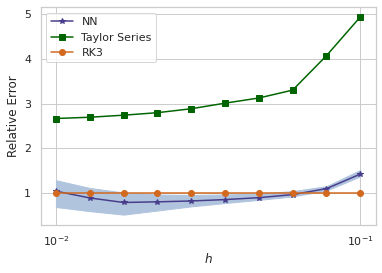

In [32]:
plot(summary_21)
# plt.savefig('results/Brusselator/Bru_alphaOutside_GMean.pdf', dpi=200, bbox_inches='tight')

## Random $alpha$, Outside $y_{0}$

In [33]:
y1 = tf.random.uniform(    
    minval=0.5,
    maxval=1.5,
    shape=(n_samples, 1),
    dtype='float64'
)

y2 = tf.random.uniform(
    minval=1.0,
    maxval=2.0,
    shape=(n_samples, 1),
    dtype='float64'
)
y0s = tf.concat([y1,y2], axis=-1)


In [34]:
df_22 = pd.DataFrame()
hs, errors_rk_mse = evaluator_GMean.evaluate(integrator=rk3, target=target_2, n_samples=n_samples, y0=y0s)
hs, errors_ty_mse = evaluator_GMean.evaluate(integrator=taylorseries, target=target_2, n_samples=n_samples, y0=y0s)

for i in range(3):
    rk_nn_2.model.load_weights('results/Brusselator/weights/bru_rk3_'+str(i)+'.h5')
    hs, errors_nn_mse = evaluator_GMean.evaluate(integrator=rk_nn_2, target=target_2, n_samples=n_samples, y0=y0s)    
    df_22['nn'+str(i+1)] = np.array(errors_nn_mse)/np.array(errors_rk_mse)

df_22['rk'] = np.array(errors_rk_mse)/np.array(errors_rk_mse)
df_22['ty'] = np.array(errors_ty_mse)/np.array(errors_rk_mse)
df_22['hs'] = hs

m_22 = pd.melt(df_22, id_vars=['hs','rk','ty'])
# get mean/std
summary_22 = m_22.groupby('hs').agg([GMean, np.max, np.min])

100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


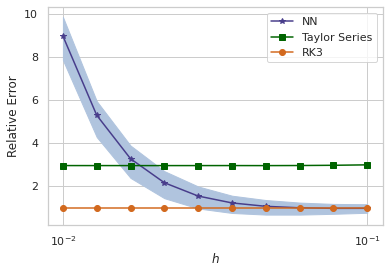

In [35]:
plot(summary_22)
# plt.savefig('results/Brusselator/Bru_y0Outside_GMean.pdf', dpi=200, bbox_inches='tight')